# Analysis of Foursquare Data Using Kmeans Clustering

In [69]:
import os
import requests
import shapely
import json


# !pip install pydotplus
from sklearn import tree
from IPython.display import Image  
import pydotplus


import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# NYU - CUSP UDP Capstone
# Foursquare + NYC Merge by CT 
## Brief
This notebook 
- import Foursquare data
- imports the Census Tract shapefile
- import Typologies
- merges topologies
- Spatail join by Census Tract
- merges topologies
- map topologies
- map Businesses
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/updny_2

# Foursquare Data
- import Foursquare data

In [52]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

In [53]:
(list(data.columns)), data.shape

([u'id',
  u'Place Name',
  u'Rating',
  u'Checkins',
  u'Users',
  u'Visits',
  u'Pricing',
  u'Type',
  u'Category',
  u'Class',
  'geometry'],
 (106287, 11))

In [54]:
data.head(1)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,NaN,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)


In [55]:
list(data.columns)[-4:-1]

[u'Type', u'Category', u'Class']

In [56]:
X_dummies = data[list(data.columns)[-4:-1]]
print(X_dummies.shape)
X_dummies = pd.get_dummies(X_dummies)
Fq_dummies = pd.concat([data, X_dummies], axis=1, join='inner')  
Fq_dummies.shape

(106287, 3)


(106287, 716)

# Census Tract shapefile
- imports the Census Tract shapefile


In [7]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/Capstone/udpny_2


In [8]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)


Master: /nfshome/mv1742/Capstone/udpny_2


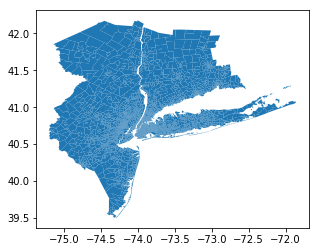

In [9]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('Censustracts/region.shp')
NYCzip.plot()


In [10]:
NYCzip.columns

Index([  u'aland_mi',   u'objectid',    u'statefp',   u'countyfp',
          u'tractce',      u'geoid',       u'name',   u'namelsad',
            u'mtfcc',   u'funcstat',      u'aland',     u'awater',
         u'intptlat',   u'intptlon', u'shape_leng', u'shape_area',
           u'atotal',  u'atotal_mi', u'cartodb_id',    u'geoid_1',
            u'hou16',   u'hou16moe',    u'hou16cv',     u'houv16',
        u'houv16moe',   u'houv16cv',     u'houo16',  u'houo16moe',
         u'houo16cv',     u'hour16',  u'hour16moe',   u'hour16cv',
          u'emtot15',     u'empr15',    u'emoff15',    u'emins15',
          u'emind15',    u'emser15',    u'emoth15',   u'geometry'],
      dtype='object')

In [11]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

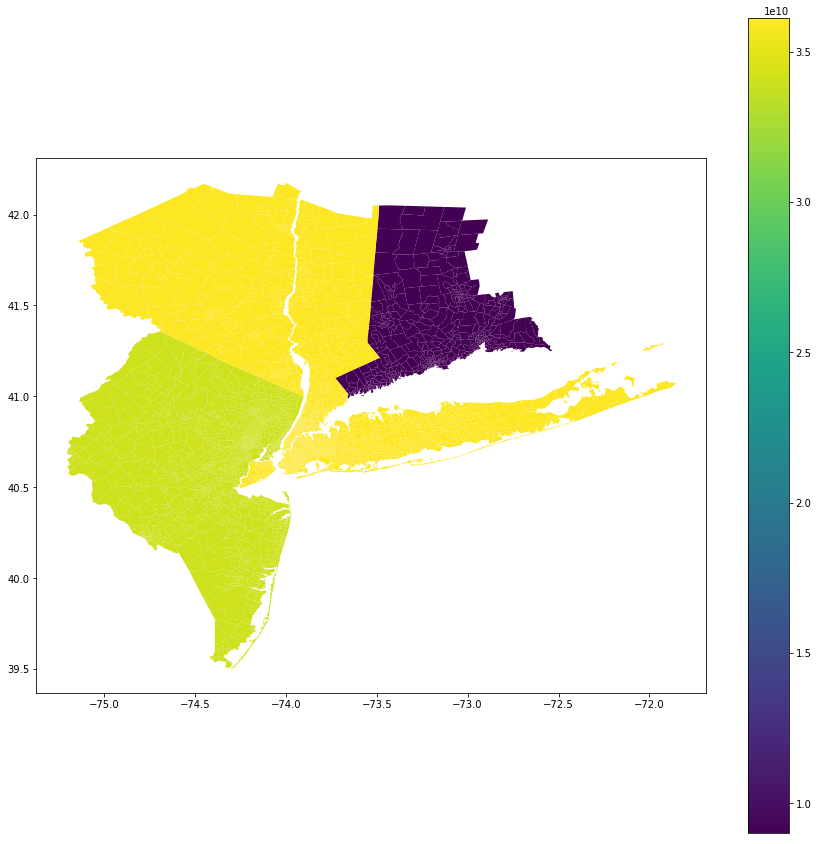

In [12]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Typologies
- import Typologies
- merges topologies
- map topologies

In [13]:
Typologiespd=pd.read_csv('NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
len(Typologiesgdp.columns)

82

In [14]:
Typologiesgdp['Type_1.19'].unique()

array(['VHI - Super Gentrification or Exclusion',
       'MHI - Ongoing Exclusion',
       'MHI - Stable or Early Stage of Exclusion',
       'MHI - Advanced Exclusion', 'LI - At Risk of Gentrification',
       'MHI - Advanced Gentrification',
       'LI - Not Losing Low-Income Households',
       'LI - Ongoing Displacement of Low-Income Households',
       'Missing Data', 'LI - Ongoing Gentrification', nan], dtype=object)

In [15]:
# Typologiesgdp['Type_binary'] = Typologiesgdp['Type_1.19']
# Typologiesgdp['Type_binary'].replace('VHI - Super Gentrification or Exclusion',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - At Risk of Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('Missing Data',0,inplace=True)
# Typologiesgdp['Type_binary'].replace(nan,0,inplace=True)


In [16]:
# Typologiesgdp['Type_binary'].unique()

In [17]:
# Typologiesgdp.to_csv('typologies_binary.csv')
# Typologiesgdp.drop(columns='Type_binary', inplace=True)

In [18]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()
cols_typ = ['GEOID','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<type 'numpy.float64'>


,GEOID,Type_1.19
0,9.001010e+09,VHI - Super Gentrification or Exclusion
1,9.001010e+09,VHI - Super Gentrification or Exclusion
2,9.001010e+09,VHI - Super Gentrification or Exclusion
3,9.001010e+09,VHI - Super Gentrification or Exclusion
4,9.001010e+09,VHI - Super Gentrification or Exclusion


In [19]:
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
merged.tail()

,GEOID,geometry,Type_1.19
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,Missing Data
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,LI - Ongoing Gentrification
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",LI - Ongoing Displacement of Low-Income Househ...
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,LI - Ongoing Gentrification
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",MHI - Stable or Early Stage of Exclusion


In [20]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

(<class 'geopandas.geodataframe.GeoDataFrame'>, (5290, 3))


(5290, 3)

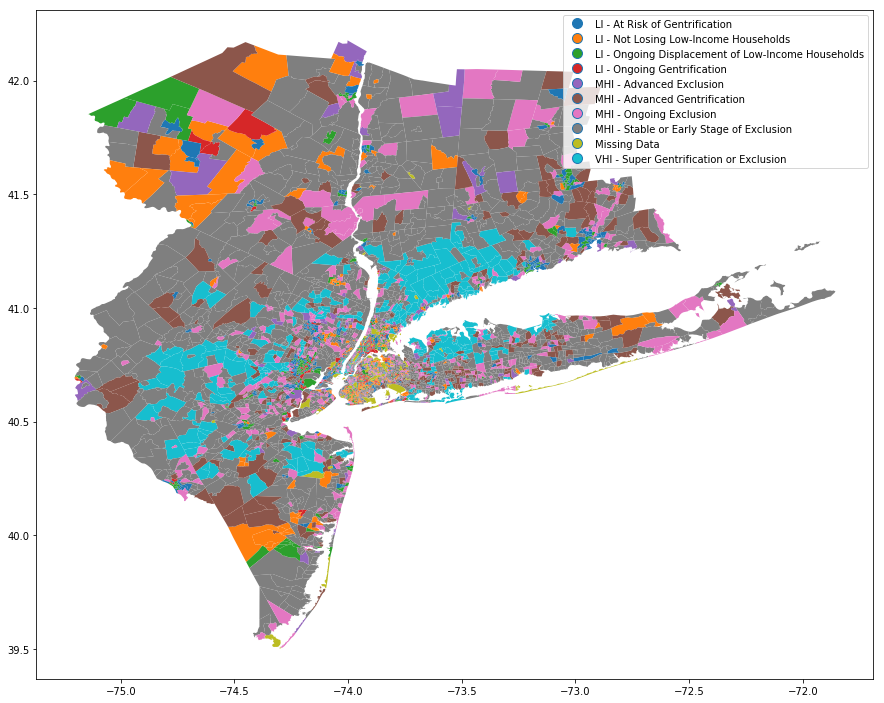

In [21]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

# Spatail Join
- Spatail join by Census Tract
- map Businesses


In [22]:
mergedgpd.crs, data.crs, mergedgpd.shape, data.shape

(None, {u'init': u'epsg:4326'}, (5290, 3), (106287, 11))

In [23]:
mergedgpd.crs = {'init' :'epsg:4326'}

In [24]:
mergedgpd.crs

{'init': 'epsg:4326'}

In [25]:
data_sjoined = gpd.sjoin(mergedgpd,Fq_dummies, op="contains")

In [26]:
# data_sjoined

In [27]:
# list(data_sjoined.columns)

In [28]:
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()
print(data_sjoined_sum.shape,data_sjoined_sum.columns)
data_sjoined_sum_merged = data_sjoined_sum.merge(mergedgpd.loc[:,['GEOID','Type_1.19', 'geometry']],on='GEOID')
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)
data_sjoined_sum_merged = gpd.GeoDataFrame(data_sjoined_sum_merged)
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)

((3009, 711), Index([           u'index_right',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
             u'Category_Leisure',      u'Category_Mobility',
           u'Category_Nutrition', u'Category_Personal care',
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional'],
      dtype='object', length=711))
((3009, 714), Index([                 u'GEOID',            u'index_right',
                       u'Rating',               u'Checkins',
                        u'Users',                 u'Visits',
                      u'Pricing',               u'Type_ATM',
       u'Type_Accessories Store',     u'Type_Acupuncturist',
       ...

In [29]:
Fq_dummies.shape,data_sjoined_sum.shape, len(data_sjoined_sum_merged.GEOID.unique())

((106287, 716), (3009, 711), 3009)

In [30]:
data_sjoined_sum_merged.rename(columns={"Type_1.19": "Typologies"}, inplace = True)

/nfshome/mv1742/.conda/envs/myEnv/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


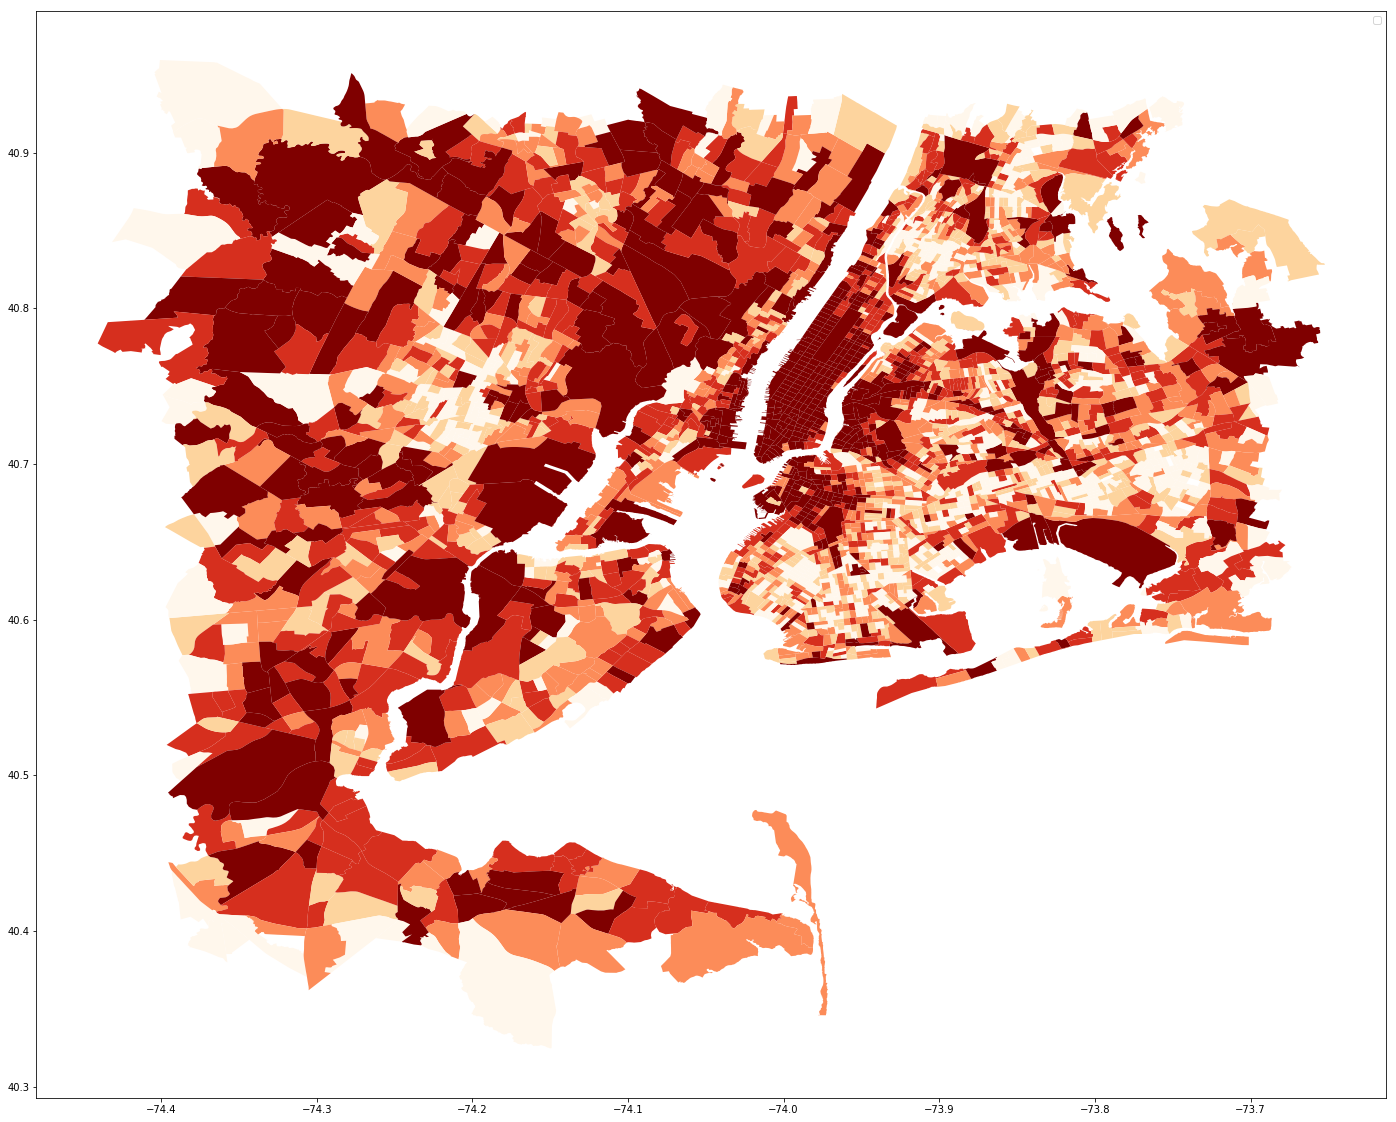

In [31]:
plt.rcParams['figure.figsize'] = (30, 20)
ax = data_sjoined_sum_merged.plot(column='Checkins', scheme='quantiles', cmap='OrRd')
ax.legend()

In [32]:
data_sjoined_sum_merged.drop(columns= 'index_right',inplace=True)
data_sjoined_sum_merged.iloc[:,:6]
data_sjoined_sum_merged.columns

Index([                 u'GEOID',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
           u'Category_Nutrition', u'Category_Personal care',
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional',
                   u'Typologies',               u'geometry'],
      dtype='object', length=713)

In [37]:
# sfig = pd.scatter_matrix(data_sjoined_sum_merged.iloc[:,:6], s=30, figsize=(10, 10), diagonal='kde')

In [38]:
data_sjoined_sum_merged.columns

Index([                 u'GEOID',                 u'Rating',
                     u'Checkins',                  u'Users',
                       u'Visits',                u'Pricing',
                     u'Type_ATM', u'Type_Accessories Store',
           u'Type_Acupuncturist',    u'Type_Adult Boutique',
       ...
           u'Category_Nutrition', u'Category_Personal care',
              u'Category_Social',   u'Category_Taking care',
             u'Category_Unknown',                 u'Class_',
              u'Class_Necessary',         u'Class_Optional',
                   u'Typologies',               u'geometry'],
      dtype='object', length=713)

### Analysis ## FOURSQUARE ONLY

In [91]:
### Preprocessing Data
### Preprocessing Data
X_foursquare = data_sjoined_sum_merged.drop(['Typologies','GEOID','geometry'],axis =1).copy()
# X_foursquare = data_sjoined_sum_merged.drop(['Typologies', 'geometry'],axis =1).copy()
y = data_sjoined_sum_merged.Typologies

## change to zeros

# replace with mean/median

# create a new

print(X_foursquare.shape)
# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
# X_foursquare.replace(nan,0,inplace=True)

X_foursquare.dropna(inplace=True)
print(X_foursquare.shape)

(3009, 710)
(3009, 710)


In [108]:
for string in data_sjoined_sum_merged.columns:
    print(string)
#     data_sjoined_sum_merged.rename({string:str(string.encode('utf-8'))},axis='columns',inplace=True)
list(data_sjoined_sum_merged.columns)

GEOID
Rating
Checkins
Users
Visits
Pricing
Type_ATM
Type_Accessories Store
Type_Acupuncturist
Type_Adult Boutique
Type_Adult Education Center
Type_Advertising Agency
Type_Afghan Restaurant
Type_African Restaurant
Type_Airport
Type_Airport Food Court
Type_Airport Gate
Type_Airport Lounge
Type_Airport Service
Type_Airport Terminal
Type_Airport Tram
Type_Alternative Healer
Type_American Restaurant
Type_Amphitheater
Type_Animal Shelter
Type_Antique Shop
Type_Apres Ski Bar
Type_Aquarium
Type_Arcade
Type_Arepa Restaurant
Type_Argentinian Restaurant
Type_Art Gallery
Type_Art Museum
Type_Art Studio
Type_Arts & Crafts Store
Type_Arts & Entertainment
Type_Asian Restaurant
Type_Assisted Living
Type_Astrologer
Type_Athletics & Sports
Type_Auditorium
Type_Australian Restaurant
Type_Austrian Restaurant
Type_Auto Dealership
Type_Auto Garage
Type_Auto Workshop
Type_Automotive Shop
Type_BBQ Joint
Type_Baby Store
Type_Badminton Court
Type_Bagel Shop
Type_Baggage Claim
Type_Bakery
Type_Ballroom
Type_Bank

['GEOID',
 'Rating',
 'Checkins',
 'Users',
 'Visits',
 'Pricing',
 'Type_ATM',
 'Type_Accessories Store',
 'Type_Acupuncturist',
 'Type_Adult Boutique',
 'Type_Adult Education Center',
 'Type_Advertising Agency',
 'Type_Afghan Restaurant',
 'Type_African Restaurant',
 'Type_Airport',
 'Type_Airport Food Court',
 'Type_Airport Gate',
 'Type_Airport Lounge',
 'Type_Airport Service',
 'Type_Airport Terminal',
 'Type_Airport Tram',
 'Type_Alternative Healer',
 'Type_American Restaurant',
 'Type_Amphitheater',
 'Type_Animal Shelter',
 'Type_Antique Shop',
 'Type_Apres Ski Bar',
 'Type_Aquarium',
 'Type_Arcade',
 'Type_Arepa Restaurant',
 'Type_Argentinian Restaurant',
 'Type_Art Gallery',
 'Type_Art Museum',
 'Type_Art Studio',
 'Type_Arts & Crafts Store',
 'Type_Arts & Entertainment',
 'Type_Asian Restaurant',
 'Type_Assisted Living',
 'Type_Astrologer',
 'Type_Athletics & Sports',
 'Type_Auditorium',
 'Type_Australian Restaurant',
 'Type_Austrian Restaurant',
 'Type_Auto Dealership',
 'T

In [110]:
data_sjoined_sum_merged.columns

Index([u'GEOID', u'Rating', u'Checkins', u'Users', u'Visits', u'Pricing',
       u'Type_ATM', u'Type_Accessories Store', u'Type_Acupuncturist',
       u'Type_Adult Boutique',
       ...
       u'Category_Nutrition', u'Category_Personal care', u'Category_Social',
       u'Category_Taking care', u'Category_Unknown', u'Class_',
       u'Class_Necessary', u'Class_Optional', u'Typologies', u'geometry'],
      dtype='object', length=713)

In [111]:
data_sjoined_sum_merged.to_csv('data_sjoined_sum_merged.csv')
data_sjoined_sum_merged.columns

Index([u'GEOID', u'Rating', u'Checkins', u'Users', u'Visits', u'Pricing',
       u'Type_ATM', u'Type_Accessories Store', u'Type_Acupuncturist',
       u'Type_Adult Boutique',
       ...
       u'Category_Nutrition', u'Category_Personal care', u'Category_Social',
       u'Category_Taking care', u'Category_Unknown', u'Class_',
       u'Class_Necessary', u'Class_Optional', u'Typologies', u'geometry'],
      dtype='object', length=713)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_foursquare, y, test_size = 0.3, random_state = 1)    

In [124]:
R2 = {}
model = {}
modelslist = ['Logit','DT','RF','NB','SVM'] 

# LR

In [125]:
## Logistic Reeg
#logistics regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

import matplotlib.pylab
%pylab inline
# logit_ = LogisticReg(C = 10000)
logit_1 = LogisticRegression(C = 10000)
print(X_train.shape,y_train.shape)
# logit_.fit(X_train, y_train)
logit_1.fit(X_train, y_train)
# print(logit_.score(X_test,y_test))
print(logit_1.score(X_test,y_test))
model['Logit'] = logit_1.score(X_test,y_test)

Populating the interactive namespace from numpy and matplotlib
((2106, 710), (2106,))


/nfshome/mv1742/.conda/envs/myEnv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0.2868217054263566


# DT

In [112]:
# Decision Tree
# Decision Tree
OS=[]
R2_train=[]
R2_test=[]
# for i in range(10):
#     print(X_test.shape,y_test.shape)
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train,y_train)
R2_train.append(dt.score(X_train, y_train))
R2_test.append(dt.score(X_test, y_test))
OS.append(dt.score(X_test,y_test))
print(np.mean(OS))
print("R2_train:",mean(R2_train),"\n R2_test",mean(R2_test))



0.26799557032115173
('R2_train:', 0.30626780626780625, '\n R2_test', 0.26799557032115173)


In [113]:
# Xc_pdcolumns = X_train.columns
# Xc_pdcolumns_new  = []
# for string in Xc_pdcolumns:
#     print(string)
#     string = str(string.encode('utf-8'))  # or:
#     Xc_pdcolumns_new.append(string)
# print(Xc_pdcolumns_new)

In [114]:
# !python --version


In [115]:
# thestring=tree.export_graphviz(dt)
# thestring=tree.export_graphviz(dt,out_file=None,
#                          feature_names=Xc_pdcolumns_new,  
#                          class_names=Xc_pdcolumns_new,  
# #                          class_names=dt.classes_,  
#                                filled=True, rounded=True,  
#                          special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
# # If you want to install GraphViz on your own machine:


# # pip install pydot

# # pip install pydotplus

# # For people who experienced this error: "GraphViz's executables not found"

# # http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

# graph = pydotplus.graph_from_dot_data(thestring)  
# Image(graph.create_png())

In [130]:
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.

param_grid = {'max_depth':range(1,11),'max_leaf_nodes':range(2,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid,scoring='accuracy')
rs=gr.fit(X_train,y_train)
print (rs.best_params_)
model['DT'] = gr.score(X_test,y_test)
model

{'max_leaf_nodes': 2, 'max_depth': 1}


{'DT': 0.28349944629014395, 'Logit': 0.283499446290144}

In [131]:
OS=[]
for i in range(2,500,25):
    dt=DecisionTreeClassifier(max_leaf_nodes=2)
    dt.fit(X_train,y_train)
    OS.append(dt.score(X_test,y_test))
np.mean(OS), np.max(OS)

(0.283499446290144, 0.28349944629014395)

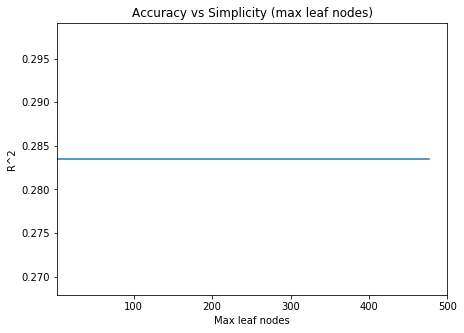

In [151]:
import matplotlib.pylab as plt
plt.figure(figsize=(7,5))
plt.plot(range(2,500,25),OS)
plt.xlabel("Max leaf nodes")
plt.ylabel("R^2")
plt.title("Accuracy vs Simplicity (max leaf nodes)")
plt.xlim(2,500)
plt.show()

In [133]:
# def featureImportancePlot(dt, labels):
#     '''plots feature importance for random forest
#     rf: the random forest model fit to the data
#     labels: the names of the features
#     '''
    
#     importances = dt.feature_importances_[:10]
#     indices = np.argsort(importances)[::-1]
#     std = np.std([tree.feature_importances_ for tree in dt.estimators_],
#              axis=0)

#     pl.figure()
#     pl.title("Feature importances")
#     pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
#        color="SteelBlue", yerr=std[indices], align="center")
#     pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
#     pl.xlim([-1, indices.shape[0]])
#     pl.show()
# featureImportancePlot(dt, X_foursquare.columns)

# Random Forest

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score



((2106,), (2106, 710))
0.2857142857142857


In [136]:
param_grid = {'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
rf=RandomForestClassifier()
gr=GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
rs=gr.fit(X_train,y_train)
print (rs.best_params_)
model['RF'] = gr.score(X_test,y_test)
model

{'n_estimators': 9, 'max_leaf_nodes': 10}


[0.28349944629014395, 0.28349944629014395, 0.28349944629014395, 0.27353266888150607, 0.28792912513842744, 0.28349944629014395, 0.2724252491694352, 0.27464008859357697, 0.27353266888150607, 0.2768549280177187, 0.2901439645625692, 0.2779623477297896, 0.2779623477297896, 0.2823920265780731, 0.2702104097452935, 0.26688815060908083, 0.27353266888150607, 0.28349944629014395]


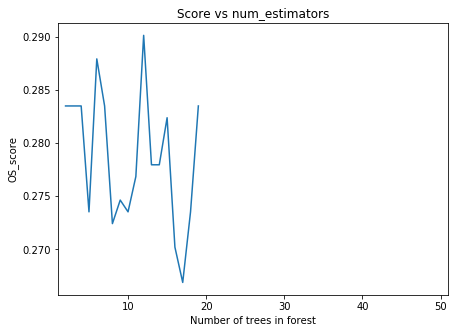

In [135]:

score=[]
for i in range(2,20,1):
    rf = RandomForestClassifier(n_estimators=1, max_leaf_nodes=i)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)

plt.figure(figsize=(7,5))
plt.plot(range(2,20,1),score)
plt.xlabel("Number of trees in forest")
plt.ylabel("OS_score")
plt.title("Score vs num_estimators")
plt.xlim(1,51)
plt.show()

In [143]:
seed = 5
print(y_train.shape, X_train.shape)


rf = RandomForestClassifier(n_estimators=9,max_leaf_nodes=10)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
model['RF'] = rf.score(X_test,y_test)

print(model['RF'])


((2106,), (2106, 710))
0.28349944629014395


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[0.26245847176079734, 0.2868217054263566, 0.28017718715393136, 0.2779623477297896, 0.2823920265780731, 0.2857142857142857, 0.2857142857142857, 0.2823920265780731, 0.2857142857142857, 0.28349944629014395, 0.28349944629014395, 0.28349944629014395, 0.2812846068660022, 0.28349944629014395, 0.28349944629014395, 0.28349944629014395, 0.28349944629014395, 0.28349944629014395, 0.28349944629014395]


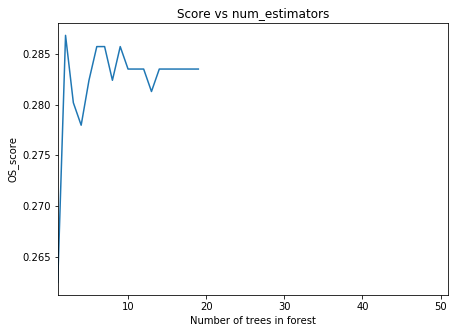

In [144]:

score=[]
for i in range(1,20,1):
    print(i)
    rf = RandomForestClassifier(n_estimators=i, max_leaf_nodes=10)
    rf.fit(X_train, y_train)
    pred=rf.predict_proba(X_test)
#     print(X_test.shape)
#     print(pred.shape,y_test.shape)
    score.append(rf.score(X_test,y_test))
print(score)

plt.figure(figsize=(7,5))
plt.plot(range(1,20,1),score)
plt.xlabel("Number of trees in forest")
plt.ylabel("OS_score")
plt.title("Score vs num_estimators")
plt.xlim(1,51)
plt.show()

In [150]:
for i in model.values():
    print(i)
model.keys(), model.values()

0.283499446290144
0.2857142857142857
0.28349944629014395


(['Logit', 'DT', 'RF'],
 [0.283499446290144, 0.2857142857142857, 0.28349944629014395])

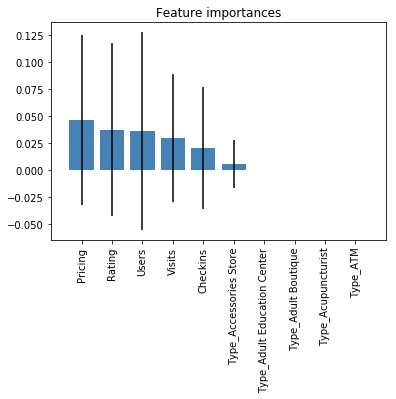

In [145]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:10]
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
featureImportancePlot(rf, X_foursquare.columns)

# Output
- outputs a .csv of the results
- You can refer to https://github.com/mv1742/updny_2